In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from scipy.stats import shapiro, f_oneway, ttest_ind
from statsmodels.tsa.stattools import adfuller

## Read data

In [131]:
df_train = pd.read_parquet('train.parquet')
df_train

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0


In [132]:
df_test = pd.read_parquet('test.parquet')
df_test

,id,dates,values
0,6125,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.85, -0.04, 0.19, -0.45, -0.75, -0.95, -2.91..."
1,26781,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.41, 0.39, -0.47, -0.9, -1.46, -0.51, 0.51,..."
2,13333,"[2016-06-01, 2016-07-01, 2016-08-01, 2016-09-0...","[-0.29, -1.26, 0.17, -1.22, 0.45, -0.94, 0.16,..."
3,53218,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.47, 1.55, -0.03, 0.57, -0.57, 0.6, 0.27, 1..."
4,84204,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.33, 1.39, -1.03, -2.64, 1.89, 1.77, 1.43, 1..."
...,...,...,...
19995,80341,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[3.01, -0.58, 1.55, 0.48, -0.35, 1.93, 3.86, 2..."
19996,5891,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[0.66, 1.3, 2.78, -0.25, -1.97, -0.55, -1.08, ..."
19997,29091,"[2017-01-01, 2017-02-01, 2017-03-01, 2017-04-0...","[0.09, 0.44, 1.55, 0.15, 0.3, 0.19, 0.34, 1.05..."
19998,85877,"[2017-04-01, 2017-05-01, 2017-06-01, 2017-07-0...","[0.28, 1.92, 1.14, 2.4, 1.46, 1.08, -0.12, 0.6..."


##

##

## Data preprocessing, features creation from id, datetime, values and labels

In [133]:
def createTimeSeriesFeatures(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    
    for _, row in df.iterrows():
        dates = row['dates']
        values = row['values']
        label = row['label']
        
        combined = list(zip(dates, values))
        
        for date, value in combined:
            rows.append({
                'id': row['id'],
                'date': date,
                'value': value,
                'label': label
            })
    
    long_df = pd.DataFrame(rows)
    
    long_df['date'] = pd.to_datetime(long_df['date'])

    long_df['year'] = long_df['date'].dt.year
    long_df['month'] = long_df['date'].dt.month
    long_df['day'] = long_df['date'].dt.day
    long_df['day_of_week'] = long_df['date'].dt.dayofweek

    return long_df

In [134]:
features_df = createTimeSeriesFeatures(df_train)

features_df

,id,date,value,label,year,month,day,day_of_week
0,19114,2016-01-01,-1.86000,0.0,2016,1,1,4
1,19114,2016-02-01,0.79000,0.0,2016,2,1,0
2,19114,2016-03-01,1.40000,0.0,2016,3,1,1
3,19114,2016-04-01,0.15000,0.0,2016,4,1,4
4,19114,2016-05-01,0.00000,0.0,2016,5,1,6
...,...,...,...,...,...,...,...,...
5155407,98870,2019-11-01,1.40335,1.0,2019,11,1,4
5155408,98870,2019-12-01,0.26335,1.0,2019,12,1,6
5155409,98870,2020-01-01,-1.73665,1.0,2020,1,1,2
5155410,98870,2020-02-01,-0.38665,1.0,2020,2,1,5


#### Check for nulls

In [135]:
features_df.isnull().sum()

id                0
date              0
value          4582
label             0
year              0
month             0
day               0
day_of_week       0
dtype: int64

In [136]:
mean_value = features_df['value'].mean()
features_df.fillna(mean_value, inplace=True)
features_df

,id,date,value,label,year,month,day,day_of_week
0,19114,2016-01-01,-1.86000,0.0,2016,1,1,4
1,19114,2016-02-01,0.79000,0.0,2016,2,1,0
2,19114,2016-03-01,1.40000,0.0,2016,3,1,1
3,19114,2016-04-01,0.15000,0.0,2016,4,1,4
4,19114,2016-05-01,0.00000,0.0,2016,5,1,6
...,...,...,...,...,...,...,...,...
5155407,98870,2019-11-01,1.40335,1.0,2019,11,1,4
5155408,98870,2019-12-01,0.26335,1.0,2019,12,1,6
5155409,98870,2020-01-01,-1.73665,1.0,2020,1,1,2
5155410,98870,2020-02-01,-0.38665,1.0,2020,2,1,5


In [137]:
features_df.isnull().sum()

id             0
date           0
value          0
label          0
year           0
month          0
day            0
day_of_week    0
dtype: int64

In [138]:
features_df.info, features_df.shape

(<bound method DataFrame.info of             id       date    value  label  year  month  day  day_of_week
 0        19114 2016-01-01 -1.86000    0.0  2016      1    1            4
 1        19114 2016-02-01  0.79000    0.0  2016      2    1            0
 2        19114 2016-03-01  1.40000    0.0  2016      3    1            1
 3        19114 2016-04-01  0.15000    0.0  2016      4    1            4
 4        19114 2016-05-01  0.00000    0.0  2016      5    1            6
 ...        ...        ...      ...    ...   ...    ...  ...          ...
 5155407  98870 2019-11-01  1.40335    1.0  2019     11    1            4
 5155408  98870 2019-12-01  0.26335    1.0  2019     12    1            6
 5155409  98870 2020-01-01 -1.73665    1.0  2020      1    1            2
 5155410  98870 2020-02-01 -0.38665    1.0  2020      2    1            5
 5155411  98870 2020-03-01 -1.72665    1.0  2020      3    1            6
 
 [5155412 rows x 8 columns]>,
 (5155412, 8))

In [139]:
features_df.describe().T

,count,mean,min,25%,50%,75%,max,std
id,5155412.0,50108.527821,0.0,25105.75,50149.0,75067.0,99999.0,28865.001711
date,5155412,2019-03-08 08:15:07.744793856,2016-01-01 00:00:00,2017-09-01 00:00:00,2019-02-01 00:00:00,2020-07-01 00:00:00,2024-01-01 00:00:00,NaN
value,5155412.0,-0.029833,-7.95,-0.84,-0.12,0.76,9.54,1.22424
label,5155412.0,0.273854,0.0,0.0,0.0,1.0,1.0,0.445935
year,5155412.0,2018.734503,2016.0,2017.0,2019.0,2020.0,2024.0,1.862358
month,5155412.0,6.38347,1.0,3.0,6.0,9.0,12.0,3.443433
day,5155412.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
day_of_week,5155412.0,3.018144,0.0,1.0,3.0,5.0,6.0,1.983396


##

##

## Feature generation

#### First feature is just value mean for each id

In [140]:
mean_values = features_df.groupby('id')['value'].mean().reset_index()
mean_values.columns = ['id', 'mean_value']
features_df = features_df.merge(mean_values, on='id', how='left')

features_df

,id,date,value,label,year,month,day,day_of_week,mean_value
0,19114,2016-01-01,-1.86000,0.0,2016,1,1,4,0.023710
1,19114,2016-02-01,0.79000,0.0,2016,2,1,0,0.023710
2,19114,2016-03-01,1.40000,0.0,2016,3,1,1,0.023710
3,19114,2016-04-01,0.15000,0.0,2016,4,1,4,0.023710
4,19114,2016-05-01,0.00000,0.0,2016,5,1,6,0.023710
...,...,...,...,...,...,...,...,...,...
5155407,98870,2019-11-01,1.40335,1.0,2019,11,1,4,-0.274635
5155408,98870,2019-12-01,0.26335,1.0,2019,12,1,6,-0.274635
5155409,98870,2020-01-01,-1.73665,1.0,2020,1,1,2,-0.274635
5155410,98870,2020-02-01,-0.38665,1.0,2020,2,1,5,-0.274635


#### Second feature will be generated seasons from months data. This feature can help us detect seasonal changes or dependencies.

In [141]:
def categorizeSeasons(value: int) -> str:
    if value == 12 or value == 1 or value == 2:
        return 'winter'
    elif value in range(3, 6):
        return 'spring'
    elif value in range(6, 9):
        return 'summer'
    else:
        return 'autumn'

In [142]:
features_df['is_winter'] = features_df['month'].apply(lambda x: 1 if categorizeSeasons(x) == 'winter' else 0)
features_df['is_spring'] = features_df['month'].apply(lambda x: 1 if categorizeSeasons(x) == 'spring' else 0)
features_df['is_summer'] = features_df['month'].apply(lambda x: 1 if categorizeSeasons(x) == 'summer' else 0)
features_df['is_autumn'] = features_df['month'].apply(lambda x: 1 if categorizeSeasons(x) == 'autumn' else 0)

features_df

,id,date,value,label,year,month,day,day_of_week,mean_value,is_winter,is_spring,is_summer,is_autumn
0,19114,2016-01-01,-1.86000,0.0,2016,1,1,4,0.023710,1,0,0,0
1,19114,2016-02-01,0.79000,0.0,2016,2,1,0,0.023710,1,0,0,0
2,19114,2016-03-01,1.40000,0.0,2016,3,1,1,0.023710,0,1,0,0
3,19114,2016-04-01,0.15000,0.0,2016,4,1,4,0.023710,0,1,0,0
4,19114,2016-05-01,0.00000,0.0,2016,5,1,6,0.023710,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5155407,98870,2019-11-01,1.40335,1.0,2019,11,1,4,-0.274635,0,0,0,1
5155408,98870,2019-12-01,0.26335,1.0,2019,12,1,6,-0.274635,1,0,0,0
5155409,98870,2020-01-01,-1.73665,1.0,2020,1,1,2,-0.274635,1,0,0,0
5155410,98870,2020-02-01,-0.38665,1.0,2020,2,1,5,-0.274635,1,0,0,0


#### Third feature will be mean values on the period of 6 months. This can help us to seek any trends

In [143]:
features_df.set_index('date', inplace=True)
features_df.sort_index(inplace=True)
features_df['mean_period_180d'] = features_df['value'].rolling(window='180D').mean()

features_df.reset_index(inplace=True)

features_df

,date,id,value,label,year,month,day,day_of_week,mean_value,is_winter,is_spring,is_summer,is_autumn,mean_period_180d
0,2016-01-01,19114,-1.86,0.0,2016,1,1,4,0.023710,1,0,0,0,-1.860000
1,2016-01-01,77873,1.17,0.0,2016,1,1,4,-0.042222,1,0,0,0,-0.345000
2,2016-01-01,94991,0.42,0.0,2016,1,1,4,0.004179,1,0,0,0,-0.090000
3,2016-01-01,81111,-0.05,1.0,2016,1,1,4,-0.424984,1,0,0,0,-0.080000
4,2016-01-01,76208,1.23,1.0,2016,1,1,4,-0.073426,1,0,0,0,0.182000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5155407,2024-01-01,32158,-3.61,0.0,2024,1,1,0,0.152581,1,0,0,0,-0.311421
5155408,2024-01-01,35735,0.62,0.0,2024,1,1,0,0.160417,1,0,0,0,-0.311384
5155409,2024-01-01,60425,1.47,0.0,2024,1,1,0,-0.036667,1,0,0,0,-0.311315
5155410,2024-01-01,47557,-1.61,0.0,2024,1,1,0,0.062500,1,0,0,0,-0.311366


#### Fourth feature is just season

In [144]:
def categorizeSeasonsFloats(value: int) -> int:
    if value == 12 or value == 1 or value == 2:
        return 1
    elif value in range(3, 6):
        return 2
    elif value in range(6, 9):
        return 3
    else:
        return 4

In [145]:
features_df['season'] = features_df['month'].apply(categorizeSeasonsFloats)
features_df

,date,id,value,label,year,month,day,day_of_week,mean_value,is_winter,is_spring,is_summer,is_autumn,mean_period_180d,season
0,2016-01-01,19114,-1.86,0.0,2016,1,1,4,0.023710,1,0,0,0,-1.860000,1
1,2016-01-01,77873,1.17,0.0,2016,1,1,4,-0.042222,1,0,0,0,-0.345000,1
2,2016-01-01,94991,0.42,0.0,2016,1,1,4,0.004179,1,0,0,0,-0.090000,1
3,2016-01-01,81111,-0.05,1.0,2016,1,1,4,-0.424984,1,0,0,0,-0.080000,1
4,2016-01-01,76208,1.23,1.0,2016,1,1,4,-0.073426,1,0,0,0,0.182000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5155407,2024-01-01,32158,-3.61,0.0,2024,1,1,0,0.152581,1,0,0,0,-0.311421,1
5155408,2024-01-01,35735,0.62,0.0,2024,1,1,0,0.160417,1,0,0,0,-0.311384,1
5155409,2024-01-01,60425,1.47,0.0,2024,1,1,0,-0.036667,1,0,0,0,-0.311315,1
5155410,2024-01-01,47557,-1.61,0.0,2024,1,1,0,0.062500,1,0,0,0,-0.311366,1


In [146]:
winter = features_df[features_df['season'] == 1]
spring = features_df[features_df['season'] == 2]
summer = features_df[features_df['season'] == 3]
autumn = features_df[features_df['season'] == 4]

categorized_data_seasons = [winter, spring, summer, autumn]

##

##

## EDA

#### Classes distribution based on label

<Axes: xlabel='label'>

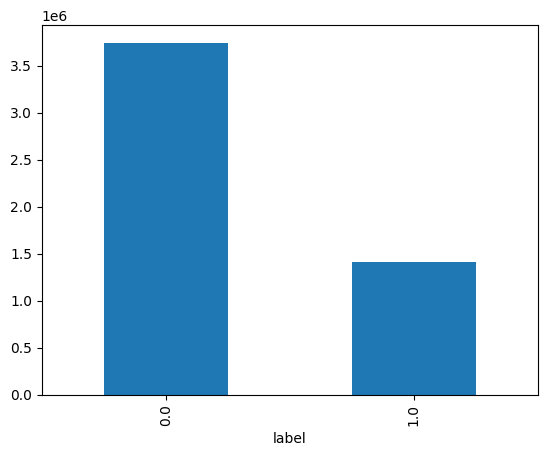

In [147]:
features_df['label'].value_counts().plot(kind='bar')

#### Values column data boxplot distribution

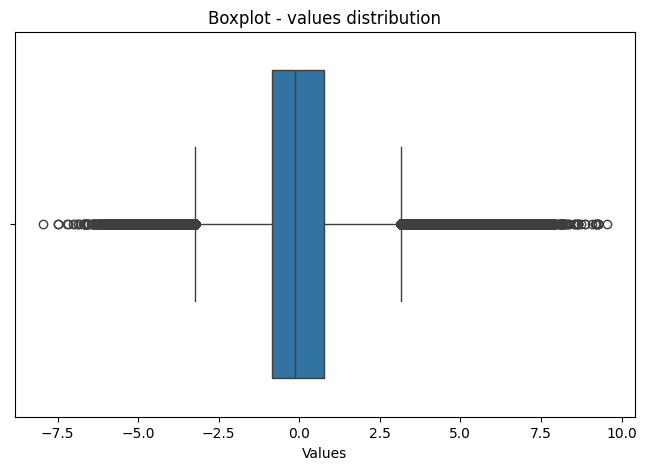

In [148]:
plt.figure(figsize=(8,5))
sns.boxplot(data=features_df, x='value')
plt.xlabel('Values')
plt.title(f'Boxplot - values distribution');

#### Statistics for value column

In [ ]:
features_df['value'].apply(lambda x: pd.Series(x)).describe()

#### Graphs showing mean values depending on timestamp

In [ ]:
yearly_avg = features_df.groupby('year')['value'].mean()

plt.figure(figsize=(12, 6))

plt.plot(yearly_avg.index, yearly_avg.values, marker='o')
plt.title('Years mean values')
plt.xlabel('Year')
plt.ylabel('Mean')
plt.grid()
plt.xticks(yearly_avg.index)
plt.show()

In [ ]:
monthly_avg = features_df.groupby('month')['value'].mean()

plt.figure(figsize=(12, 6))

plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.title('Months mean values')
plt.ylabel('Mean')
plt.grid()
plt.xticks(monthly_avg.index)
plt.show()

In [ ]:
weekly_avg = features_df.groupby('day_of_week')['value'].mean()

plt.figure(figsize=(12, 6))

plt.plot(weekly_avg.index, weekly_avg.values, marker='o', color='orange')
plt.title('Day of the week mean values')
plt.xlabel('Day of the week(0=monday, 6=sunday)')
plt.ylabel('Mean value')
plt.grid()
plt.xticks(weekly_avg.index)
plt.show()

#### As we can see our data has some season, yearly and day of the week trends

In [ ]:
def checkNormality(data):
    sampled = [np.random.choice(data, 100) for _ in range(100)]
    means = [np.mean(sampled[i]) for i in range(100)]
    _, p = shapiro(means)
    print(f'Data is not normally distributed, p-value = {p}') if p <= 0.05 else print(f'Data is normally distributed, p-value = {p}')

In [ ]:
categorized_data_seasons = [cat.value for cat in categorized_data_seasons]

##

##

## Hypothesis testing

### Hypothesis 1

#### Is the data seasonally biased?

#### H0: $\mu_1 = \mu_2$
#### H1: $\mu_1 =/= \mu_2$

Is seasonal data normally distributed?

In [ ]:
for cat in categorized_data_seasons:
    checkNormality(cat)

Compare variances with one way ANOVA

In [ ]:
f_oneway(winter.value, spring.value, summer.value, autumn.value)

P-value is less that 0.05 => reject null hypothesis

Let's compare each sample with t-test to see which one differs

In [ ]:
ttest_ind(winter['value'], spring['value']), ttest_ind(winter['value'], summer['value']), ttest_ind(winter.value, autumn.value)

In [ ]:
ttest_ind(spring.value, summer.value), ttest_ind(spring.value, autumn.value)

In [ ]:
ttest_ind(summer['value'], autumn['value'])

#### Conclusion: our groups are very different

##

##

## Classification with catboost

#### Hyperparameter picking

In [ ]:
labels = features_df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)

#### Model training

In [77]:
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.000001,
    depth=6,
    cat_features=[],
    verbose=100,
    random_seed=42
)

model.fit(X_train, y_train)

0:	learn: 0.6931489	total: 442ms	remaining: 3m 40s
100:	learn: 0.6929911	total: 41s	remaining: 2m 41s
200:	learn: 0.6925840	total: 1m 19s	remaining: 1m 58s
300:	learn: 0.6924438	total: 1m 58s	remaining: 1m 18s
400:	learn: 0.6903293	total: 2m 36s	remaining: 38.5s
499:	learn: 0.6899698	total: 3m 14s	remaining: 0us


In [78]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [79]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.9999999999999999


In [ ]:
def createTimeSeriesFeaturesTest(df):
    rows = []
    for _, row in df.iterrows():
        dates = row['dates']
        values = row['values']
        
        combined = list(zip(dates, values))
        for date, value in combined:
            rows.append({
                'id': row['id'],
                'date': date,
                'value': value,
            })

    long_df = pd.DataFrame(rows)
    long_df['date'] = pd.to_datetime(long_df['date'])
    
    long_df['year'] = long_df['date'].dt.year
    long_df['month'] = long_df['date'].dt.month
    long_df['day'] = long_df['date'].dt.day
    long_df['day_of_week'] = long_df['date'].dt.dayofweek

    return long_df

In [ ]:
features_test_df = createTimeSeriesFeaturesTest(df_test)
features_test_df

In [129]:
test_features = df_test[['id', 'date', 'value', 'year', 'month', 'day']]

test_predictions = model.predict_proba(test_features)[:, 1]

KeyError: "['date', 'value', 'year', 'month', 'day'] not in index"

### Paste data to result csv

In [ ]:
submission = pd.DataFrame({'id': test_df['id'], 'label': test_predictions})
submission.to_csv('submission.csv', index=False)